# Data Exploration

Explore the preprocessed data (see [data_preprocessing](./data_preprocessing.ipynb)) in its raw form and for some of its feature transforms.

In [ ]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
from tools.audio_tools import read_audio, play_audio
from tools.feature_tools import compute_stft, compute_istft, compute_mels, compute_imels, compute_mfcc, compute_imfcc
from tools.constants import cut_classical_path, cut_jazz_path, default_sample_rate
from tools.plot_tools import plot_spectral_feature, plot_audio, make_figax

In [5]:
# Some constants
transform_labels = ["STFT", "MELS", "MFCC"]
transform_transforms = [compute_stft, compute_mels, compute_mfcc]
transform_inverse_transforms = [compute_istft, compute_imels, compute_imfcc]

genre_labels = ["CLASSICAL", "JAZZ"]
genre_paths = [cut_classical_path, cut_jazz_path]

fraction = 1/8

CLASSICAL
audio_file = '1727_455.wav'
len(audio) = 32768


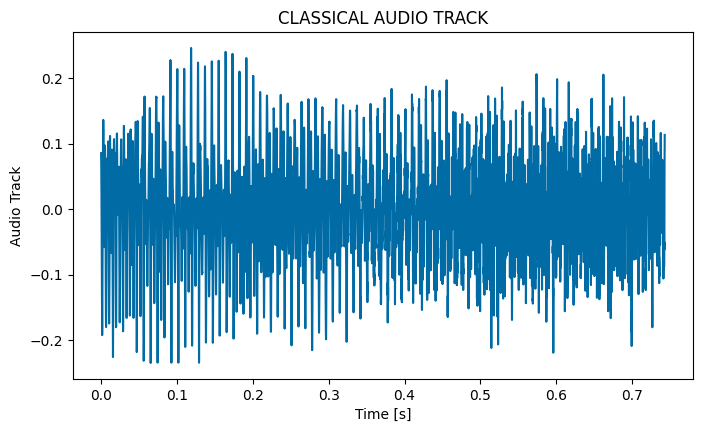

CLASSICAL PLAYER


STFT
transform.shape = (67, 1025)
transform.size = 68675
transform element = (0.010415956377983093+0.00527503527700901j)


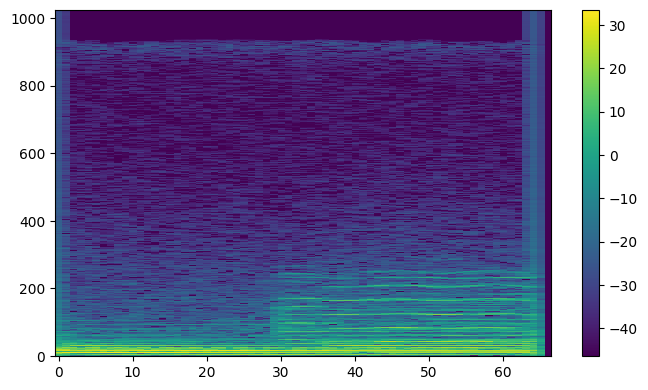

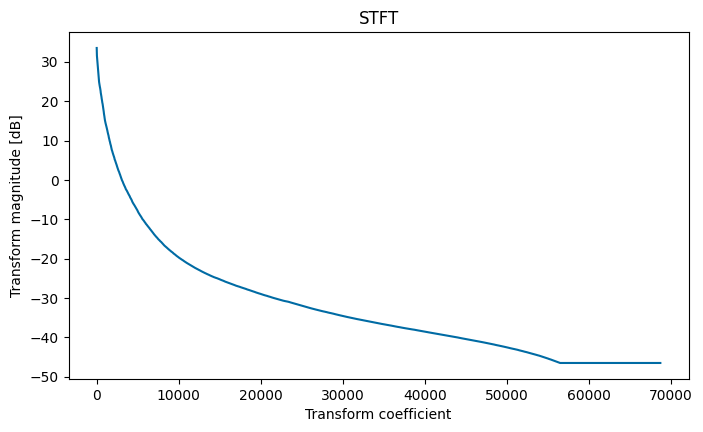

INVERSE STFT - CLASSICAL


INVERSE STFT - CLASSICAL - TOP K
Reconstructing from 1/8.00 of the samples: k = 8584


MELS
transform.shape = (67, 128)
transform.size = 8576
transform element = 0.0003269600565545261


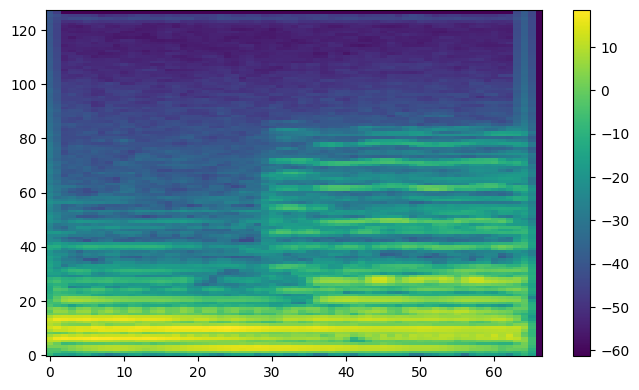

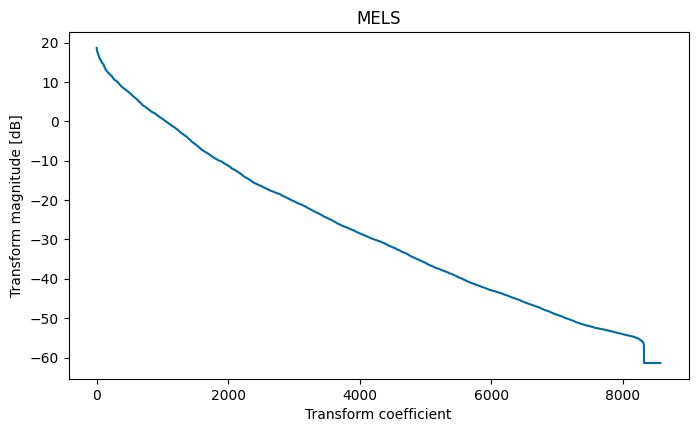

INVERSE MELS - CLASSICAL


INVERSE MELS - CLASSICAL - TOP K
Reconstructing from 1/8.00 of the samples: k = 1072


MFCC
transform.shape = (67, 128)
transform.size = 8576
transform element = -3.851776361465454


/tmp/ipykernel_22580/204460361.py:36: RuntimeWarning: divide by zero encountered in log10
  fn = lambda x: 20*np.log10(np.abs(x))


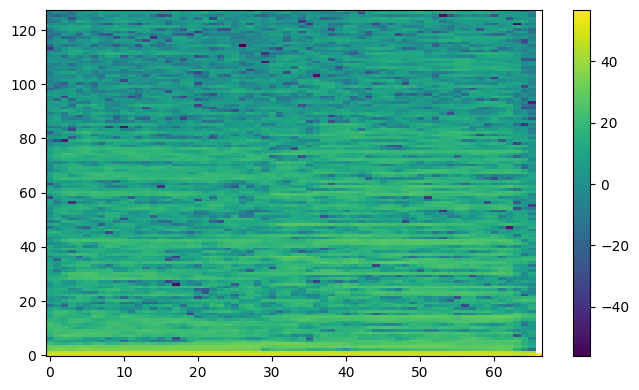

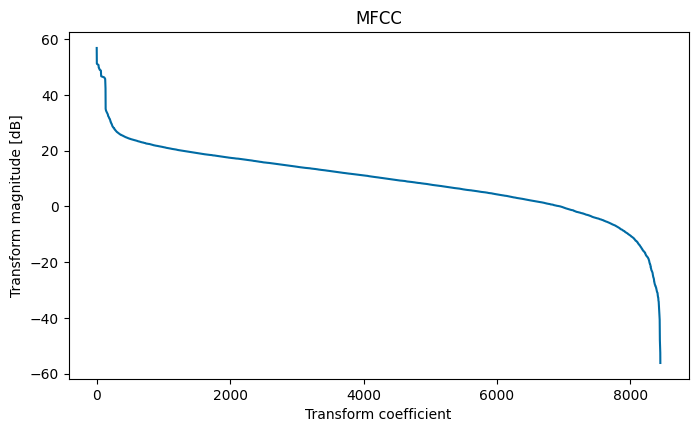

INVERSE MFCC - CLASSICAL


INVERSE MFCC - CLASSICAL - TOP K
Reconstructing from 1/8.00 of the samples: k = 1072


JAZZ
audio_file = '09--Dee_Yan-Key-drive_home_57.wav'
len(audio) = 32768


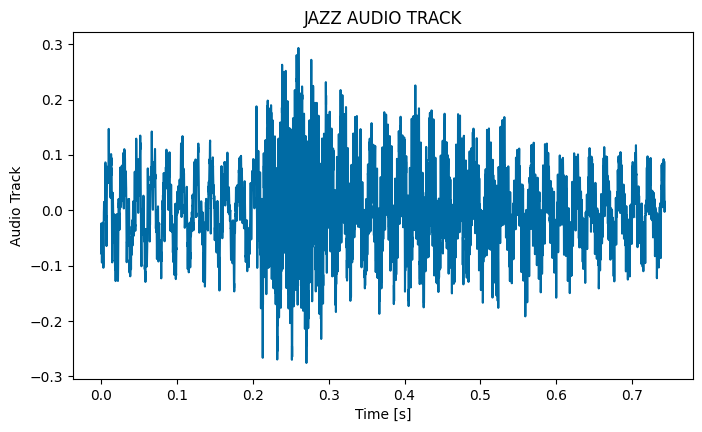

JAZZ PLAYER


STFT
transform.shape = (67, 1025)
transform.size = 68675
transform element = (0.007670757360756397+0.004939554259181023j)


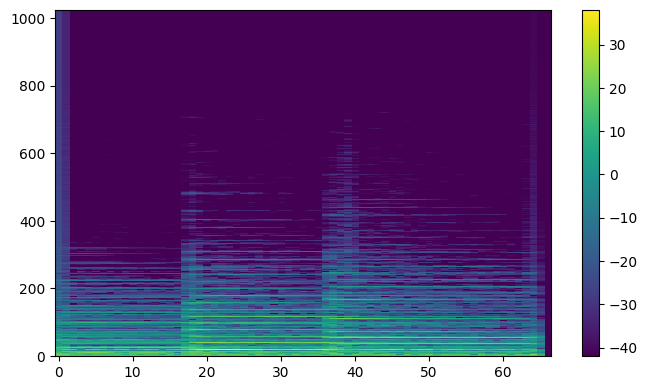

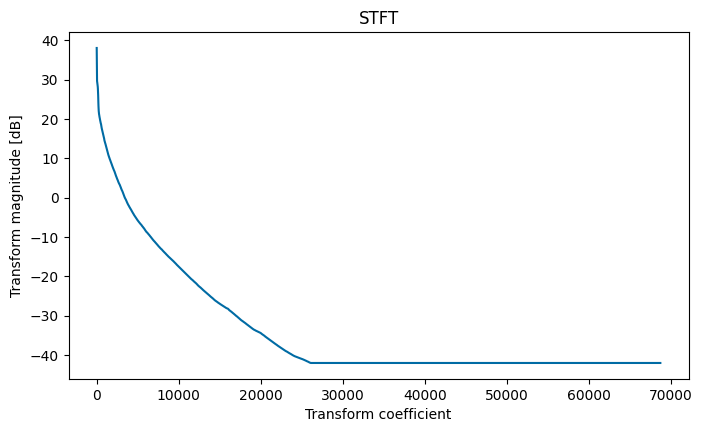

INVERSE STFT - JAZZ


INVERSE STFT - JAZZ - TOP K
Reconstructing from 1/8.00 of the samples: k = 8584


MELS
transform.shape = (67, 128)
transform.size = 8576
transform element = 0.0007701333961449564


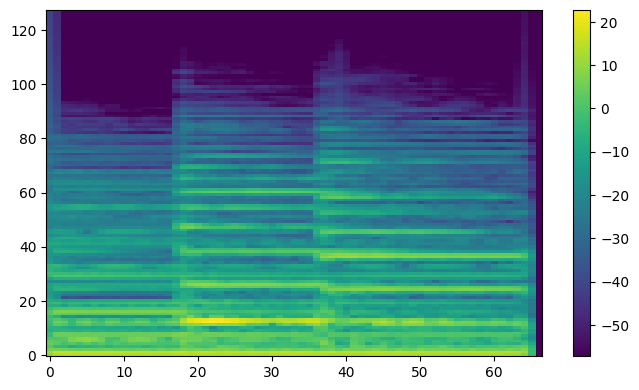

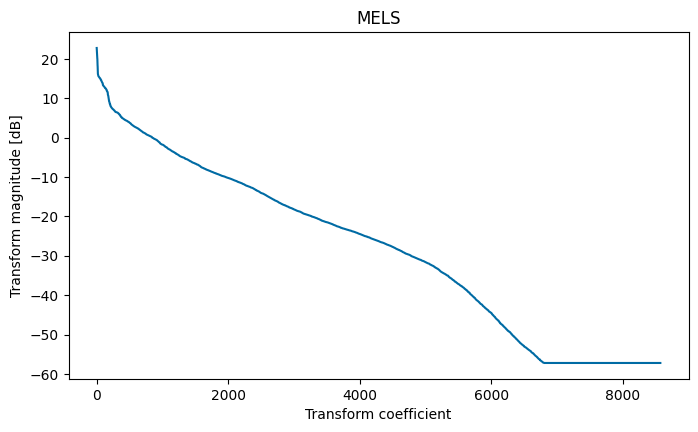

INVERSE MELS - JAZZ


INVERSE MELS - JAZZ - TOP K
Reconstructing from 1/8.00 of the samples: k = 1072


MFCC
transform.shape = (67, 128)
transform.size = 8576
transform element = -4.911825656890869


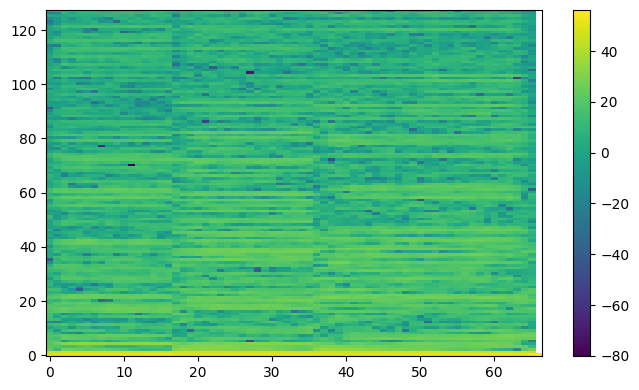

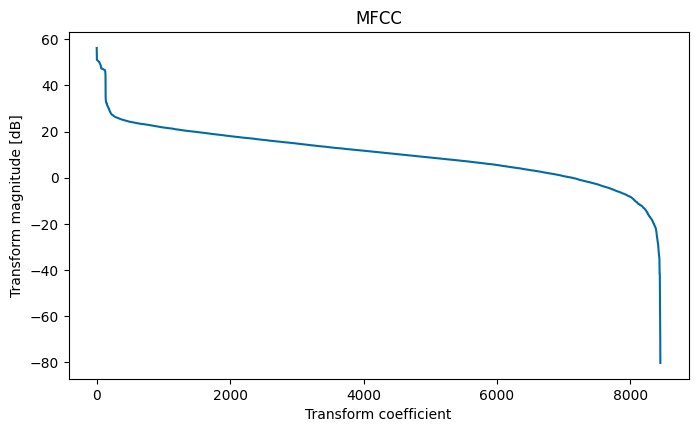

INVERSE MFCC - JAZZ


INVERSE MFCC - JAZZ - TOP K
Reconstructing from 1/8.00 of the samples: k = 1072


In [6]:
# Explore transform spaces for all genres
for genre_label, genre_path in zip(genre_labels, genre_paths):
    print(genre_label)

    # Pick a random audio track
    audio_file = np.random.choice(os.listdir(genre_path))
    audio_path = os.path.join(genre_path, audio_file)
    audio = read_audio(audio_path)
    time = np.linspace(0, len(audio)/default_sample_rate, len(audio))
    print(f"{audio_file = }")
    print(f"{len(audio) = }")

    # Time domain plot
    fig, ax = make_figax()
    ax.plot(time, audio)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Audio Track")
    ax.set_title(f"{genre_label} AUDIO TRACK")
    plt.show()

    # Play audio
    print(f"{genre_label} PLAYER")
    player = play_audio(audio)

    # Transform to feature spaces and make plots
    for transform_label, transform_transform, transform_inverse_transform in zip(transform_labels, transform_transforms, transform_inverse_transforms):
        print(transform_label)

        # Compute transform
        transform = transform_transform(audio)
        print(f"{transform.shape = }")
        print(f"{transform.size = }")
        print(f"transform element = {np.random.choice(transform.reshape(-1))}")

        # Plot Transform in 2D
        fn = lambda x: 20*np.log10(np.abs(x))
        if transform_label == "STFT":
            fn = lambda x: lb.amplitude_to_db(np.abs(x))
        elif transform_label == "MELS":
            fn = lb.power_to_db
        fig, ax = plot_spectral_feature(transform, fn=fn)
        plt.show()

        # Plot transform coefficient roloff
        transform_fn = fn(transform)
        transform_magnitudes = np.sort(transform_fn.reshape(-1))[::-1]
        fig, ax = make_figax()
        ax.plot(transform_magnitudes)
        ax.set_xlabel("Transform coefficient")
        ax.set_ylabel("Transform magnitude [dB]")
        ax.set_title(transform_label)
        plt.show()

        # Transform reconstruct & play
        print(f"INVERSE {transform_label} - {genre_label}")
        inverse = transform_inverse_transform(transform)
        play_audio(inverse)

        # Transform reconstruct from top k & play
        print(f"INVERSE {transform_label} - {genre_label} - TOP K")
        fraction = 1/8
        k = int(transform.size * fraction)
        print(f"Reconstructing from 1/{1/fraction:.2f} of the samples: {k = }")
        transform[transform_fn <= transform_magnitudes[k]] = 0.
        inverse = transform_inverse_transform(transform)
        play_audio(inverse)